## Kaggle Spaceship Titanic Competition

##### Submitted by: Soumik Ghosh

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


/Users/soumikg/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


We are reading the data into train_df and test_df from the .csv files.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_df1 = pd.read_csv('test.csv')
train_test = pd.concat([train_df,test_df],axis=0,ignore_index=True)

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### **Data Preprocessing**

Let us look at the correlation of the features.

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


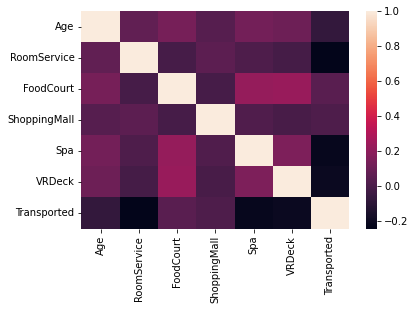

In [5]:
sns.heatmap(train_df.corr())
plt.show()



Let us look at the percentage of missing values.

In [6]:
train_df.isna().sum()/len(train_df)

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

Let us extract "GroupId" from "PassengerID".

In [7]:
train_df['GroupId'] = train_df.PassengerId.str.split('_',expand=True)[0].astype('int')
test_df['GroupId'] = test_df.PassengerId.str.split('_',expand=True)[0].astype('int')

Let is check if we have overlapping "GroupId"s between train and test data.

In [8]:
len(set(train_df['GroupId'])) + len(set(test_df['GroupId'])) - len(set(list(train_df['GroupId'])+list(test_df['GroupId'])))

0

Since "PassengerId" is nominal data, let us drop it.

In [9]:
train_df.drop(columns=['PassengerId'], inplace=True)
test_df.drop(columns=['PassengerId'], inplace=True)

Looking at "HomePlanet", we will fill the missing values with "Unknown" and rename the values.

In [10]:
train_df['HomePlanet'] = train_df['HomePlanet'].fillna(value='Unknown')
test_df['HomePlanet'] = test_df['HomePlanet'].fillna(value='Unknown')

In [11]:
home_planet = {'Earth':'X','Europa':'Y','Mars':'Z', "Unknown": 'U'}

train_df['HomePlanet'] = train_df['HomePlanet'].map(home_planet)
test_df['HomePlanet'] = test_df['HomePlanet'].map(home_planet)


Looking at "CryoSleep", we will fill the missing values with "False" because if the values are not "True" they probably the passengers are not in cryosleep.

In [12]:
train_df['CryoSleep'] = train_df['CryoSleep'].fillna(value=False)
test_df['CryoSleep'] = test_df['CryoSleep'].fillna(value=False)

Let us extract the "CabinDeck", "CabinNumber" and "CabinSide" features from the Cabin feature for more resolution and subsequently drop the "Cabin" feature. 

In [13]:
train_df['CabinDeck'] = train_df['Cabin'].str.split('/',expand=True)[0]
test_df['CabinDeck'] = test_df['Cabin'].str.split('/',expand=True)[0]

train_df['CabinNumber'] = train_df['Cabin'].str.split('/',expand=True)[1]
test_df['CabinNumber'] = test_df['Cabin'].str.split('/',expand=True)[1]

train_df['CabinSide'] = train_df['Cabin'].str.split('/',expand=True)[2]
test_df['CabinSide'] = test_df['Cabin'].str.split('/',expand=True)[2]

train_df.drop(columns=['Cabin'], inplace=True)
test_df.drop(columns=['Cabin'], inplace=True)


Now, let us fill the missing "CabinDeck" and "CabinSide" values with "U"

In [14]:
train_df['CabinDeck'] = train_df['CabinDeck'].fillna('U')
test_df['CabinDeck'] = test_df['CabinDeck'].fillna('U')

train_df['CabinSide'] = train_df['CabinDeck'].fillna('U')
test_df['CabinSide'] = test_df['CabinDeck'].fillna('U')

For "CabinNumber", we cannot impute it, because there are many values of it, and imputing it will introduce unnecessary noise. So, we will drop it..

In [15]:
train_df.drop(columns=['CabinNumber'], inplace=True)
test_df.drop(columns=['CabinNumber'], inplace=True)


For "Destination", let us find out the value counts.

In [16]:
train_df.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Let us rename the "Destination" names, and fill the null Values with "U".

In [17]:
dest = {'TRAPPIST-1e':'A','55 Cancri e':'B','PSO J318.5-22':'C'}

train_df['Destination'] = train_df['Destination'].map(dest)
train_df['Destination'] = train_df['Destination'].fillna(value='U')

test_df['Destination'] = test_df['Destination'].map(dest)
test_df['Destination'] = test_df['Destination'].fillna(value='U')

For "**Age**", we use the median to impute the values.

In [18]:
train_df['Age'] = train_df['Age'].fillna(train_df.groupby('GroupId')['Age'].transform('median'))
train_df['Age'] = train_df['Age'].fillna(train_df.groupby('HomePlanet')['Age'].transform('median'))

test_df['Age'] = test_df['Age'].fillna(test_df.groupby('GroupId')['Age'].transform('median'))
test_df['Age'] = test_df['Age'].fillna(test_df.groupby('HomePlanet')['Age'].transform('median'))

In [19]:
train_df.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
GroupId           0
CabinDeck         0
CabinSide         0
dtype: int64

Let us define a new feature "Adult" and set it to 0 if the person is below 18 years old and set it to 1 if the person is above 18 years old.

In [20]:
train_df['Adult'] = 1
train_df.loc[train_df['Age']<18, 'Adult'] = 0

test_df['Adult'] = 1
test_df.loc[test_df['Age']<18, 'Adult'] = 0


For the "VIP" feature, let us fill the missing values with "False", because if the it is not know that a passenger is a VIP, he is most likely not a VIP.

In [21]:
train_df['VIP'] = train_df['VIP'].fillna(False)
test_df['VIP'] = test_df['VIP'].fillna(False)

For NULL values of "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", we can replace them by 0, because they probably have not spent any money there, and hence they have no record.

In [22]:
train_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = train_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
test_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = test_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)

Let us define a new feature called "TotalExpenditure" to keep track of the total money spent by each passenger. 

In [23]:
train_df['TotalExpenditure'] = train_df['RoomService']+train_df['FoodCourt']+train_df['ShoppingMall']+train_df['Spa']+train_df['VRDeck']
test_df['TotalExpenditure'] = test_df['RoomService']+test_df['FoodCourt']+test_df['ShoppingMall']+test_df['Spa']+test_df['VRDeck']

For "Name", let us extract the "FamilyName" and also create a new feature "FamilySize" to count the total number of passengers under the same family name.

In [24]:
train_df['FamilyName'] = train_df['Name'].str.split(' ',expand=True)[1]
train_df['FamilyName'] = train_df['FamilyName'].fillna('Unknown')

test_df['FamilyName'] = test_df['Name'].str.split(' ',expand=True)[1]
test_df['FamilyName'] = test_df['FamilyName'].fillna('Unknown')

train_test['FamilyName'] = train_test['Name'].str.split(' ',expand=True)[1]
train_test['FamilyName'] = train_test['FamilyName'].fillna('Unknown')

family_name_dict = train_test['FamilyName'].value_counts().to_dict()
family_name_dict['Unknown'] = 0

train_df['FamilySize'] = train_df['FamilyName']
train_df['FamilySize'] = train_df['FamilySize'].map(family_name_dict)

test_df['FamilySize'] = test_df['FamilyName']
test_df['FamilySize'] = test_df['FamilySize'].map(family_name_dict)



Let us drop "Name" and "FamilyName".

In [25]:
train_df.drop(columns=['Name', 'FamilyName'], inplace=True)
test_df.drop(columns=['Name', 'FamilyName'], inplace=True)


In [26]:
train_df.drop(columns=['GroupId'], inplace=True)
test_df.drop(columns=['GroupId'], inplace=True)

Let us check for NULL values again.

In [27]:
train_df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
CabinDeck           0
CabinSide           0
Adult               0
TotalExpenditure    0
FamilySize          0
dtype: int64

Let us convert the True and False values to 1 and 0. 

In [28]:
train_df[['CryoSleep','VIP','Transported']] = train_df[['CryoSleep','VIP','Transported']].astype(int)
test_df[['CryoSleep','VIP']] = test_df[['CryoSleep','VIP']].astype(int)

We have our final Data frame.

In [29]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide,Adult,TotalExpenditure,FamilySize
0,Y,0,A,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,B,1,0.0,3
1,X,0,A,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,F,1,736.0,4
2,Y,0,A,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,A,1,10383.0,7
3,Y,0,A,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,A,1,5176.0,7
4,X,0,A,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,F,0,1091.0,9


Let us use Min-Max scalar to scale the numerical features between 0 and 1.

In [30]:
numerical_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalExpenditure','FamilySize', 'Adult']

scaler = MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df[numerical_features])
test_df_scaled = scaler.transform(test_df[numerical_features])

train_df_scaled = pd.DataFrame(data=train_df_scaled,columns=numerical_features)
test_df_scaled = pd.DataFrame(data=test_df_scaled,columns=numerical_features)

For the categorical features, let us use onehot-coding to convert them into numberical values.

In [31]:
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinSide']
train_df_encoded = pd.get_dummies(train_df[categorical_features],drop_first=True)
test_df_encoded = pd.get_dummies(test_df[categorical_features],drop_first=True)

Concatenating the scaled numerical features and the one-hot encoded categorical features.

In [32]:
x = pd.concat([train_df_scaled,train_df_encoded],axis=1)
y = train_df.Transported
X_train = pd.concat([x,y],axis=1)
X_test = pd.concat([test_df_scaled,test_df_encoded],axis=1)


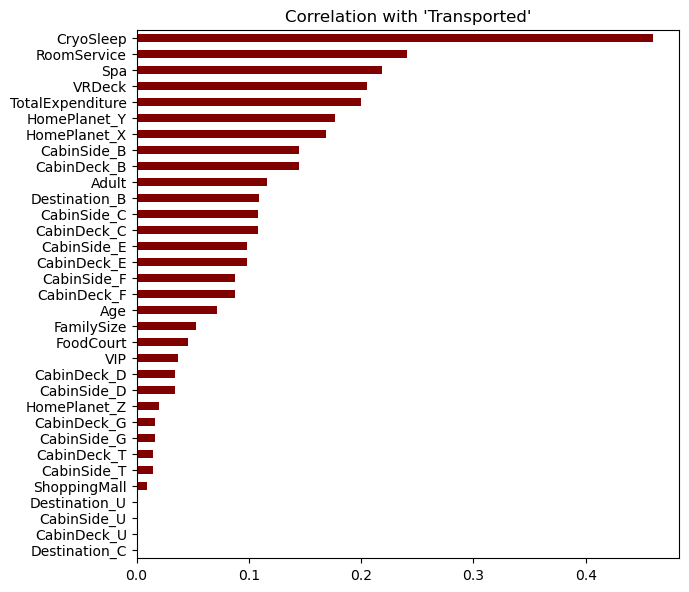

In [33]:
plt.figure(figsize=(7,7),dpi=100)
X_train.corr().Transported.abs().sort_values(ascending=True).iloc[:-1].plot.barh(color='maroon')
plt.title("Correlation with 'Transported'")
plt.show()


#### **Fitting model**

In [34]:
# catboost = CatBoostClassifier(verbose = 0, random_state=42)
# catspace = {'iterations':[300,400,500,1000],
#               'learning_rate':[0.01,0.03,0.05,0.07,0.09],
#               'depth':[2,3,5,7,10,20],
#               'l2_leaf_reg': [0.05,0.01]
#              }

# search = GridSearchCV(catboost, catspace, cv=5)
# result = search.fit(x,y)
# print('Mean score:',result.score(x,y))
# print('Best hyperparameters:',result.best_params_)

In [35]:
catboost = CatBoostClassifier(verbose=0)
catboost.fit(x,y)
predictions = catboost.predict(X_test)
output = pd.DataFrame({'PassengerId': test_df1.PassengerId, 'Transported': predictions})
output['Transported'] = output['Transported'].astype('bool')
output.to_csv('submission.csv', index=False)